In [167]:
import matplotlib.pyplot as plt
from math import exp, cos, pi
from numpy import linspace

In [168]:
class StabilityException(Exception):
    def __init__(self, tau, h):
        self.tau = tau
        self.h = h
        super().__init__(self._error_message())

    def _error_message(self):
        return f"Stability condition violated: tau / (h * h) > 0.5 (tau={self.tau}, h={self.h})"

In [169]:
def print_grid(u, K, n):
    for i in range(K):
        string = ""
        for j in range(n):
            string += f"{u[i][j]:0.5f} "
        print(string)

In [170]:
def tk(k, tau):
    return k * tau

def xi(L, i, h):
    return L + i * h

In [171]:
def Phi_L(t):
    return exp(-t) * cos(2 * t)

def Phi_R(t):
    return 0 * t

def Psi_1(x):
    return exp(-x) * cos(x)

def Psi_2(x):
    return -exp(-x) * cos(x)

In [172]:
def analytic(t, x):
    return exp(-t - x) * cos(x) * cos(2 * t)

In [173]:
def dx(f, x):
    eps = 0.000001
    return (f(x + eps) - f(x)) / eps

def ddx(f, x):
    eps = 0.000001
    return (dx(f, x + eps) - dx(f, x)) / eps

In [174]:
def explicit(n, L, R, K, T, approx=1):
    u = [[0.0 for _ in range(n + 1)] for _ in range(K + 1)]
    tau = T / K
    h = (R - L) / n
    sigma = (tau * tau) / (h * h)
    if sigma > 0.5:
        raise StabilityException(tau, h)
    for i in range(n + 1):
        u[0][i] = Psi_1(xi(L, i, h))
        if approx == 1:
            u[1][i] = Psi_2(xi(L, i, h)) * tau + u[0][i]
        elif approx == 2:
            u[1][i] = (
                u[0][i] + 
                Psi_2(xi(L, i, h)) * tau +
                (tau * tau / 2) * (
                    ddx(Psi_1, xi(L, i, h)) +
                    2 * dx(Psi_1, xi(L, i, h)) -
                    3 * Psi_1(xi(L, i, h)) -
                    2 * Psi_2(xi(L, i, h))
                )
            )
    for k in range(K + 1):
        u[k][0] = Phi_L(tk(k, tau))
        u[k][-1] = Phi_R(tk(k, tau))
    for k in range(2, K + 1):
        for i in range(1, n):
            u[k][i] = (
                u[k - 1][i] * (2 / (tau * tau)) -
                u[k - 2][i] * (1 / (tau * tau) - 1 / tau) +
                u[k - 1][i + 1] * (1 / (h * h) + 1 / h) +
                u[k - 1][i] * (-2 / (h * h) - 3) +
                u[k - 1][i - 1] * (1 / (h * h) - 1 / h)
            ) * (1 / (1 / (tau * tau) + 1 / tau))
    return u

In [175]:
def TMA(a, b, c, d):
    n = len(d)
    P = [0 for _ in range(n)]
    Q = [0 for _ in range(n)]
    P[0] = -c[0] / b[0]
    Q[0] = d[0] / b[0]
    for i in range(1, n - 1):
        P[i] = -c[i] / (b[i] + a[i] * P[i - 1])
        Q[i] = (d[i] - a[i] * Q[i - 1]) / (b[i] + a[i] * P[i - 1])
    P[-1] = 0
    Q[-1] = (d[n - 1] - a[n - 1] * Q[n - 2]) / (b[n - 1] + a[n - 1] * P[n - 2])
    x = [0 for _ in range(n)]
    x[-1] = Q[-1]
    for i in range(n - 2, -1, -1):
        x[i] = P[i] * x[i + 1] + Q[i]
    return x

In [176]:
def implicit(n, L, R, K, T, approx=1):
    u = [[0.0 for _ in range(n + 1)] for _ in range(K + 1)]
    tau = T / K
    h = (R - L) / n
    a = [0.0 for _ in range(n + 1)]
    b = [0.0 for _ in range(n + 1)]
    c = [0.0 for _ in range(n + 1)]
    d = [0.0 for _ in range(n + 1)]
    for i in range(n + 1):
        u[0][i] = Psi_1(xi(L, i, h))
        if approx == 1:
            u[1][i] = Psi_2(xi(L, i, h)) * tau + u[0][i]
        elif approx == 2:
            u[1][i] = (
                u[0][i] + 
                Psi_2(xi(L, i, h)) * tau +
                (tau * tau / 2) * (
                    ddx(Psi_1, xi(L, i, h)) +
                    2 * dx(Psi_1, xi(L, i, h)) -
                    3 * Psi_1(xi(L, i, h)) -
                    2 * Psi_2(xi(L, i, h))
                )
            )
    for k in range(1, K):
        for i in range(1, n):
            a[i] = -1 / (h * h) + 1 / h
            b[i] = 1 / (tau * tau) + 1 / tau + 2 / (h * h) + 3
            c[i] = -1 / (h * h) - 1 / h
            d[i] = -u[k][i] * (-2 / (tau * tau)) - u[k - 1][i] * (1 / (tau * tau) - 1 / tau)
        a[0] = 0
        b[0] = 1
        c[0] = 0
        d[0] = Phi_L(tk(k, tau))
        a[-1] = 0
        b[-1] = 1
        c[-1] = 0
        d[-1] = Phi_R(tk(k, tau))
        solve = TMA(a, b, c, d)
        for i in range(n):
            u[k + 1][i] = solve[i]
    return u

In [177]:
L = 0
R = pi / 2

T = 10
n = 100
K = 50000

u_explicit_1 = explicit(n, L, R, K, T, approx=1)
u_explicit_2 = explicit(n, L, R, K, T, approx=2)
u_implicit_1 = implicit(n, L, R, K, T, approx=1)
u_implicit_2 = implicit(n, L, R, K, T, approx=2)

In [178]:
tau = T / K
h = (R - L) / n

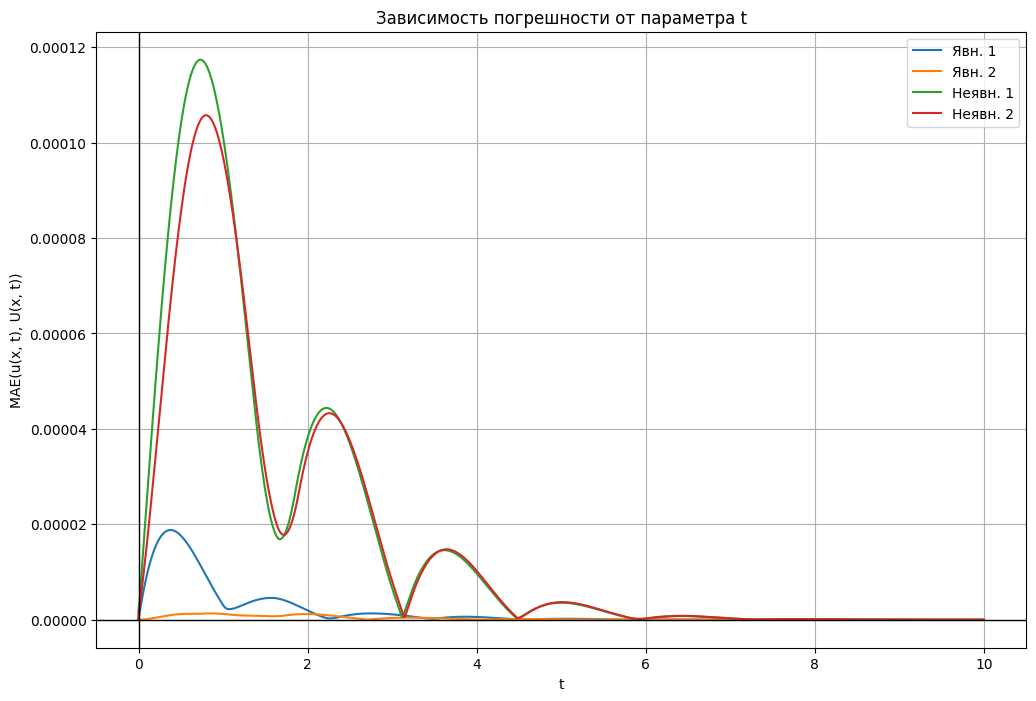

In [179]:
time = linspace(0, T, K + 1)
mae_u_explicit_1 = [0 for _ in range(K + 1)]
mae_u_explicit_2 = [0 for _ in range(K + 1)]
mae_u_implicit_1 = [0 for _ in range(K + 1)]
mae_u_implicit_2 = [0 for _ in range(K + 1)]
for k in range(K + 1):
    for i in range(n + 1):
        mae_u_explicit_1[k] += abs(u_explicit_1[k][i] - analytic(tk(k, tau), xi(L, i, h)))
        mae_u_explicit_2[k] += abs(u_explicit_2[k][i] - analytic(tk(k, tau), xi(L, i, h)))
        mae_u_implicit_1[k] += abs(u_implicit_1[k][i] - analytic(tk(k, tau), xi(L, i, h)))
        mae_u_implicit_2[k] += abs(u_implicit_2[k][i] - analytic(tk(k, tau), xi(L, i, h)))
    mae_u_explicit_1[k] /= n
    mae_u_explicit_2[k] /= n
    mae_u_implicit_1[k] /= n
    mae_u_implicit_2[k] /= n
plt.figure(figsize=(12, 8))
plt.plot(time, mae_u_explicit_1, label="Явн. 1")
plt.plot(time, mae_u_explicit_2, label="Явн. 2")
plt.plot(time, mae_u_implicit_1, label="Неявн. 1")
plt.plot(time, mae_u_implicit_2, label="Неявн. 2")
plt.xlabel('t')
plt.ylabel('MAE(u(x, t), U(x, t))')
plt.title('Зависимость погрешности от параметра t')
plt.axhline(0, color='black', linewidth=1)
plt.axvline(0, color='black', linewidth=1)
plt.legend()
plt.grid()
plt.show()

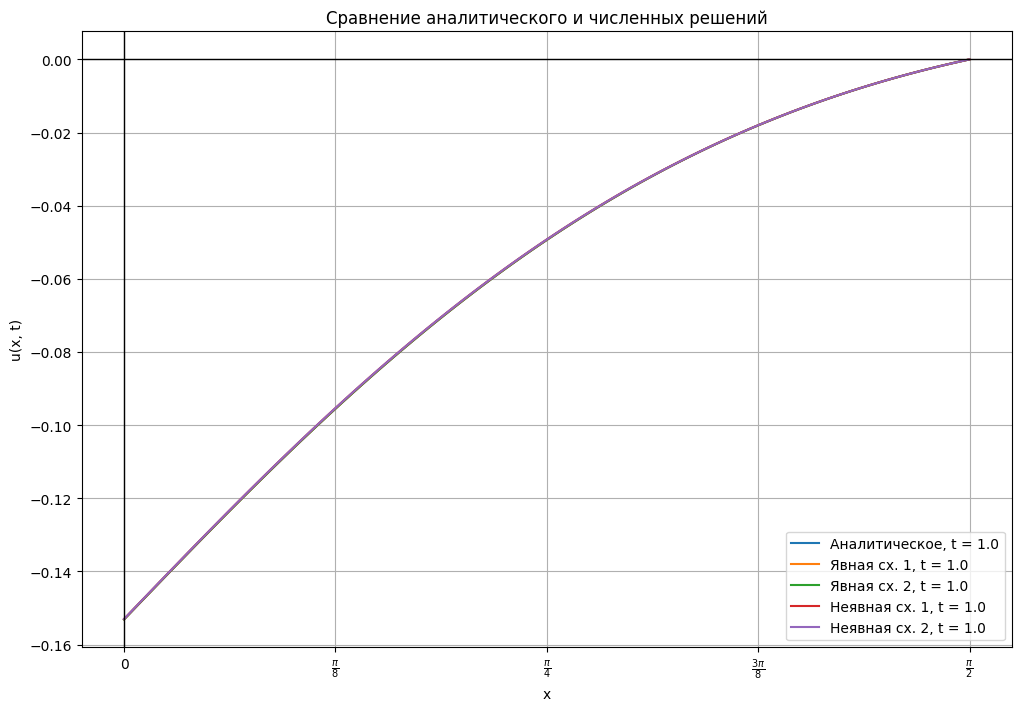

In [180]:
# time_index = int(input())
time_index = 5000
x = linspace(L, R, n + 1)
plt.figure(figsize=(12, 8))
current_time = tk(time_index, tau)
u_analytic_values = [analytic(current_time, xi(L, i, h)) for i in range(n + 1)]
u_explicit_1_values = [u_explicit_1[time_index][i] for i in range(n + 1)]
u_explicit_2_values = [u_explicit_2[time_index][i] for i in range(n + 1)]
u_implicit_1_values = [u_implicit_1[time_index][i] for i in range(n + 1)]
u_implicit_2_values = [u_implicit_2[time_index][i] for i in range(n + 1)]
plt.plot(x, u_analytic_values, label=f'Аналитическое, t = {current_time}')
plt.plot(x, u_explicit_1_values, label=f'Явная сх. 1, t = {current_time}')
plt.plot(x, u_explicit_2_values, label=f'Явная сх. 2, t = {current_time}')
plt.plot(x, u_implicit_1_values, label=f'Неявная сх. 1, t = {current_time}')
plt.plot(x, u_implicit_2_values, label=f'Неявная сх. 2, t = {current_time}')
plt.xlabel('x')
plt.ylabel('u(x, t)')
plt.title('Сравнение аналитического и численных решений')
plt.xticks(ticks=[0, pi/8, pi/4, 3*pi/8, pi/2], 
           labels=['0', r'$\frac{\pi}{8}$', r'$\frac{\pi}{4}$', r'$\frac{3\pi}{8}$', r'$\frac{\pi}{2}$'])
plt.axhline(0, color='black', linewidth=1)
plt.axvline(0, color='black', linewidth=1)
plt.legend()
plt.grid()
plt.show()